In [6]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from copy import deepcopy

class InfluenceDeinfluenceModel:
    def __init__(self, graph, edeg_weights_type = 'random'):
        self.graph = graph
        self.edge_weights(edeg_weights_type)
        self.set_initial_states()
        self.history = []  # To store the history of node states
        self.activated_edges = set()

    def edge_weights(self, type):
        if type == 'random':
            self.random_edge_weights()
        elif type == 'fixed':
            self.fixed_edge_weights(p_is=1, p_ds=1, p_di=1)
        elif type == 'dominate':
            self.dominate_edge_weights(c=1)
        else:
            print("Invalid edge weights type. Using random edge weights.")
            self.random_edge_weights()

    def random_edge_weights(self):
        for u, v in self.graph.edges:
            p_is = random.uniform(0, 1)
            p_ds = random.uniform(0, 1)
            p_di = random.uniform(0, 1)
            self.graph[u][v]['p_is'] = p_is
            self.graph[u][v]['p_ds'] = p_ds
            self.graph[u][v]['p_di'] = p_di

    def fixed_edge_weights(self, p_is, p_ds, p_di):
        for u, v in self.graph.edges:
            self.graph[u][v]['p_is'] = p_is
            self.graph[u][v]['p_ds'] = p_ds
            self.graph[u][v]['p_di'] = p_di
    
    def dominate_edge_weights(self, c):
        for u, v in self.graph.edges:
            p_is = random.uniform(0, 1)
            p_ds = 1 - (1 - p_is)**c
            p_di = 1 - (1 - p_is)**c
            self.graph[u][v]['p_is'] = p_is
            self.graph[u][v]['p_ds'] = p_ds
            self.graph[u][v]['p_di'] = p_di

    def set_initial_states(self):
        nx.set_node_attributes(self.graph, 'S', 'state')

    def set_influencers(self, influencers):
        for node in influencers:
            self.graph.nodes[node]['state'] = 'I'

    def set_deinfluencers(self, deinfluencers):
        for node in deinfluencers:
            self.graph.nodes[node]['state'] = 'D'

    def spread_influence(self):
        new_influenced = set()
        new_deinfluenced = set()

        nodes = list(self.graph.nodes)
        random.shuffle(nodes)  # Shuffle the nodes to process them in a random order

        for node in nodes:
            if self.graph.nodes[node]['state'] == 'I':
                for neighbor in self.graph.neighbors(node):
                    edge = (node, neighbor)
                    if (edge not in self.activated_edges and 
                        self.graph.nodes[neighbor]['state'] == 'S' and 
                        random.random() < self.graph[node][neighbor]['p_is']):
                        new_influenced.add(neighbor)
                        self.activated_edges.add(edge)
            elif self.graph.nodes[node]['state'] == 'D':
                for neighbor in self.graph.neighbors(node):
                    edge = (node, neighbor)
                    if edge not in self.activated_edges:
                        if (self.graph.nodes[neighbor]['state'] == 'S' and 
                            random.random() < self.graph[node][neighbor]['p_ds']):
                            new_deinfluenced.add(neighbor)
                            self.activated_edges.add(edge)
                        elif (self.graph.nodes[neighbor]['state'] == 'I' and 
                              random.random() < self.graph[node][neighbor]['p_di']):
                            new_deinfluenced.add(neighbor)
                            self.activated_edges.add(edge)

        for node in new_influenced:
            self.graph.nodes[node]['state'] = 'I'
        for node in new_deinfluenced:
            self.graph.nodes[node]['state'] = 'D'
            
        self.store_history()  # Store the state of nodes after each step

    def influencer_spread_influence(self):
        
        nodes = list(self.graph.nodes)
        new_influenced = set()

        for node in nodes:
            if self.graph.nodes[node]['state'] == 'I':
                for neighbor in self.graph.neighbors(node):
                    edge = (node, neighbor)
                    if (edge not in self.activated_edges and 
                        self.graph.nodes[neighbor]['state'] == 'S' and 
                        random.random() < self.graph[node][neighbor]['p_is']):
                        new_influenced.add(neighbor)
                        self.activated_edges.add(edge)

        for node in new_influenced:
            self.graph.nodes[node]['state'] = 'I'
        
        self.store_history()  # Store the state of nodes after each step

    def store_history(self):
        # Store a copy of the current state of all nodes
        current_state = {node: self.graph.nodes[node]['state'] for node in self.graph.nodes}
        self.history.append(current_state)

    def run_cascade(self, steps):
        self.store_history()  # Store the initial state
        for _ in range(steps):
            self.spread_influence()

    def run_cascade_influencer(self, steps):
        for _ in range(steps):
            self.influencer_spread_influence()

    def get_history(self):
        return self.history
    
    def evaluate_deinfluence(self):
        return sum(1 for node in self.graph.nodes if self.graph.nodes[node]['state'] == 'D')

    def display_graph(self, step):
        if step < 0 or step >= len(self.history):
            print(f"Step {step} is out of range")
            return

        current_state = self.history[step]
        color_map = ['red' if current_state[node] == 'I' else 'blue' if current_state[node] == 'D' else 'lightgrey' for node in self.graph.nodes]

        pos = nx.spring_layout(self.graph)
        plt.figure(figsize=(12, 8), dpi=200)  # Increase the figure size and DPI
        nx.draw(self.graph, pos, with_labels=True, node_color=color_map, arrows=True)
        edge_labels = {(u, v): f"{self.graph[u][v]['p_is']:.2f}\n{self.graph[u][v]['p_ds']:.2f}\n{self.graph[u][v]['p_di']:.2f}" for u, v in self.graph.edges}
        #nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=5)
        plt.title(f'Step {step}')
        plt.show()

    def display_graphs_grid(self):
        steps = len(self.history)
        cols = 3
        rows = (steps + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axs = axs.flatten()

        pos = nx.spring_layout(self.graph)
        for i in range(steps):
            ax = axs[i]
            current_state = self.history[i]
            color_map = ['red' if current_state[node] == 'I' else 'blue' if current_state[node] == 'D' else 'lightgrey' for node in self.graph.nodes]

            nx.draw(self.graph, pos, ax=ax, with_labels=True, node_color=color_map, arrows=True)
            edge_labels = {(u, v): f"{self.graph[u][v]['p_is']:.2f}\n{self.graph[u][v]['p_ds']:.2f}\n{self.graph[u][v]['p_di']:.2f}" for u, v in self.graph.edges}
            #nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=8)
            ax.set_title(f'Step {i}')

        for j in range(steps, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()

    def evaluate_influence(self):
        """Evaluate the number of influenced nodes."""
        influenced_count = sum(1 for node in self.graph.nodes if self.graph.nodes[node]['state'] == 'I')
        return influenced_count

    def count_deinfluenced(self):
        return sum(1 for node in self.graph.nodes if self.graph.nodes[node]['state'] == 'D')

    def greedy_hill_climbing(self, k, steps, R=50):
        """Select k initial influencers using the improved greedy algorithm."""
        best_influencers = set()

        for _ in range(k):
            best_candidate = None
            best_score = -1

            for node in self.graph.nodes:
                if node in best_influencers:
                    continue
                
                # Temporarily add the candidate node to the set of influencers
                current_influencers = best_influencers | {node}
                total_score = 0

                for _ in range(R):
                    self.activated_edges.clear()  # Reset activated edges
                    self.set_initial_states()
                    self.set_influencers(current_influencers)
                    self.run_cascade_influencer(steps)
                    total_score += self.evaluate_influence()

                avg_score = total_score / R

                if avg_score > best_score:
                    best_score = avg_score
                    best_candidate = node

            if best_candidate is not None:
                best_influencers.add(best_candidate)

        return best_influencers
    
    # New Greedy Algorithm
    
    def generate_random_graph(self, p):
        random_graph = nx.DiGraph()
        for u, v in self.graph.edges:
            if random.random() < p:
                random_graph.add_edge(u, v)
        print("Random Graph Edges:", random_graph.edges())  # Debugging line
        return random_graph

    def compute_reachable_set(self, graph, seeds):
        reachable = set(seeds)
        to_explore = list(seeds)
        while to_explore:
            current = to_explore.pop()
            if current in graph:  # Ensure current node exists in the graph
                for neighbor in graph.neighbors(current):
                    if neighbor not in reachable:
                        reachable.add(neighbor)
                        to_explore.append(neighbor)
        print("Reachable Set for Seeds {}: {}".format(seeds, reachable))  # Debugging line
        return reachable

    def greedy_hill_climbing_new(self, k, R=20000, p=0.1):
        """Select k initial influencers using the NewGreedyIC algorithm."""
        S = []
        for _ in range(k):
            sv = {v: 0 for v in self.graph if v not in S}
            for _ in range(R):
                G_prime = self.generate_random_graph(p)
                reachable_S = self.compute_reachable_set(G_prime, S)
                for v in sv:
                    if v not in reachable_S:
                        reachable_v = self.compute_reachable_set(G_prime, {v})
                        sv[v] += len(reachable_v)
            for v in sv:
                sv[v] /= R
            best_candidate = max(sv, key=sv.get)
            S.append(best_candidate)
        return S
    
    def reset_graph(self):
        self.set_initial_states()
        self.history = []
        self.activated_edges = set()

    def select_deinfluencers_degree_centrality(self, k):
        """Select k deinfluencers based on degree centrality."""
        centrality = nx.degree_centrality(self.graph)
        return sorted(centrality, key=centrality.get, reverse=True)[:k]

    def select_deinfluencers_closeness_centrality(self, k):
        """Select k deinfluencers based on closeness centrality."""
        centrality = nx.closeness_centrality(self.graph)
        return sorted(centrality, key=centrality.get, reverse=True)[:k]

    def select_deinfluencers_betweenness_centrality(self, k):
        """Select k deinfluencers based on betweenness centrality."""
        centrality = nx.betweenness_centrality(self.graph)
        return sorted(centrality, key=centrality.get, reverse=True)[:k]

    def select_deinfluencers_eigenvector_centrality(self, k, max_iter=1000, tol=1e-06):
        """Select k deinfluencers based on eigenvector centrality."""
        try:
            centrality = nx.eigenvector_centrality(self.graph, max_iter=max_iter, tol=tol)
        except nx.PowerIterationFailedConvergence:
            print(f"Power iteration failed to converge within {max_iter} iterations")
            return []
        
        return sorted(centrality, key=centrality.get, reverse=True)[:k]

    def select_deinfluencers_pagerank_centrality(self, k):
        """Select k deinfluencers based on pagerank centrality."""
        centrality = nx.pagerank(self.graph)
        return sorted(centrality, key=centrality.get, reverse=True)[:k]
    
    def select_deinfluencers_random(self, k):
        """Select k random deinfluencers."""
        population = sorted(self.graph.nodes)
        return random.sample(population, k)

In [34]:
# Generate the graph
G = nx.erdos_renyi_graph(100, 0.1, directed=True)
# G = nx.watts_strogatz_graph(100, 4, 0.1).to_directed()
# G = nx.barabasi_albert_graph(200, 3).to_directed()

# Initialize the InfluenceDeinfluenceModel
model = InfluenceDeinfluenceModel(G,"fixed")

k = 2
steps = 1
influencers = model.greedy_hill_climbing(k, steps)


model.set_initial_states()

print("Influencers:", influencers)

Influencers: {8, 31}


In [35]:
node1 = 8
node2 = 31

k = model.evaluate_influence()
print(k)
print(G.out_degree(node1))
print(G.out_degree(node2))

node_x_out_neighbors = set(G.successors(node1))
node_y_out_neighbors = set(G.successors(node2))
print("Node y out-neighbors:", list(node_y_out_neighbors))

common_out_neighbors = node_x_out_neighbors & node_y_out_neighbors
print("Common out-neighbors:", list(common_out_neighbors))

# Corrected condition
if k - (G.out_degree(node1) + G.out_degree(node2) + 2 - len(common_out_neighbors)) == 0:
    print("yes")
else:
    print("no")


32
15
19
Node y out-neighbors: [2, 4, 6, 9, 11, 18, 30, 38, 39, 47, 53, 56, 58, 65, 75, 76, 86, 87, 89]
Common out-neighbors: [9]
no


Degree Centrality Ranking: [11, 96]
Closeness Centrality Ranking: [11, 16]
Betweenness Centrality Ranking: [96, 11]
Eigenvector Centrality Ranking: [11, 16]
PageRank Centrality Ranking: [11, 27]
Random Deinfluencers: [71, 39]
Degree: 100.00 nodes deinfluenced on average
Closeness: 100.00 nodes deinfluenced on average
Betweenness: 100.00 nodes deinfluenced on average
Eigenvector: 100.00 nodes deinfluenced on average
PageRank: 99.00 nodes deinfluenced on average
random: 100.00 nodes deinfluenced on average


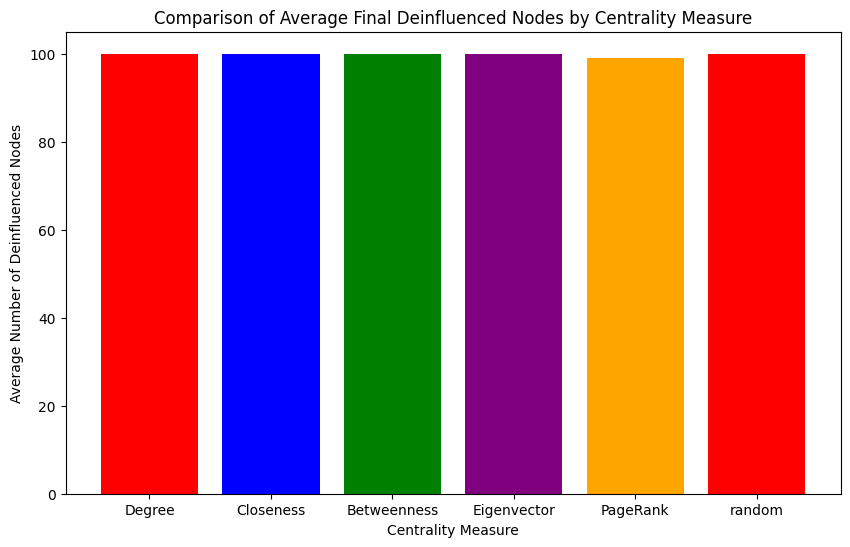

In [9]:
# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        deinfluenced_count = model.count_deinfluenced()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_deinfluenced += deinfluenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_deinfluenced

# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 2

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)


print("Degree Centrality Ranking:", degree_centrality_ranking)
print("Closeness Centrality Ranking:", closeness_centrality_ranking)
print("Betweenness Centrality Ranking:", betweenness_centrality_ranking)
print("Eigenvector Centrality Ranking:", eigenvector_centrality_ranking)
print("PageRank Centrality Ranking:", pagerank_centrality_ranking)
print("Random Deinfluencers:", random_deinfluencers)


# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 50  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

results = {
    'Degree': count_deinfluenced(model, influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, influencers, random_deinfluencers, num_runs, steps)
}

# Print the results
for centrality, count in results.items():
    print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(10, 6))  # Increase the figure size
plt.bar(results.keys(), results.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()


Aggregated Results: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


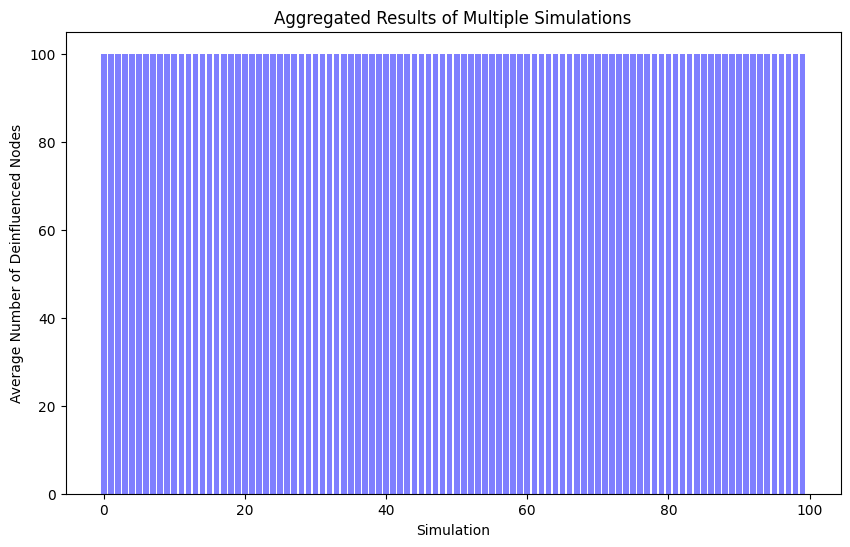

In [10]:
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store the aggregated results
aggregated_results = []

# Run the simulation k times
for i in range(k):
    # Reset the graph and set the influencers
    model.reset_graph()
    model.set_influencers(influencers)
    
    # Run the cascade and count deinfluenced nodes
    result = count_deinfluenced(model, influencers, degree_centrality_ranking, num_runs, steps)
    
    # Store the result in the aggregated_results dictionary
    aggregated_results.append(result)

print("Aggregated Results:", aggregated_results)

# Plot the aggregated results

plt.figure(figsize=(10, 6))  # Increase the figure size
for i, result in enumerate(aggregated_results):
    plt.bar(i, result, color='blue', alpha=0.5)
plt.xlabel('Simulation')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Aggregated Results of Multiple Simulations')
plt.show()